# Modèle de prévision de la cadence de production

## Mise en place de l'environnement de travail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pmdarima as pm

## Chargement des données

In [4]:
duree_cycle = pd.read_csv('data_dure_cycle_cuissant.csv', sep=';')
duree_cycle.head()

,time,m_name,Cuiseur1,Cuiseur2,Cuiseur3
0,2022-07-01 11:52:00,Duree_Cycle,NaN,NaN,149.0
1,2022-07-01 14:00:00,Duree_Cycle,NaN,NaN,126.0
2,2022-07-01 14:49:00,Duree_Cycle,NaN,114.0,NaN
3,2022-07-01 15:20:00,Duree_Cycle,127.0,NaN,NaN
4,2022-07-01 16:41:00,Duree_Cycle,NaN,105.0,NaN


In [5]:
vapeur = pd.read_csv('data_temperature_vap.csv', sep=';')
vapeur.head()

,time,m_name,Collecteur_COP_Vapeur,Cuiseur_1,Cuiseur_2,Cuiseur_3
0,2021-12-01 00:00:00,Temperature_Vapeur,179.4,176.7,179.0,178.6
1,2021-12-01 00:02:00,Temperature_Vapeur,181.5,176.2,180.2,179.8
2,2021-12-01 00:03:00,Temperature_Vapeur,183.0,176.4,181.6,181.5
3,2021-12-01 00:04:00,Temperature_Vapeur,182.4,NaN,180.9,181.8
4,2021-12-01 00:05:00,Temperature_Vapeur,182.8,176.0,181.3,181.1


In [6]:
temp_mar = pd.read_csv('data_temperature_process.csv', sep=';')
temp_mar.head()

,time,m_name,Cuiseur1,Cuiseur2,Cuiseur3
0,2022-06-08 13:52:00,Temperature_Process,100.592079,101.947144,NaN
1,2022-06-08 13:53:00,Temperature_Process,100.689735,102.069221,NaN
2,2022-06-08 13:54:00,Temperature_Process,100.567657,102.057007,NaN
3,2022-06-08 13:55:00,Temperature_Process,100.616493,102.215714,NaN
4,2022-06-08 13:56:00,Temperature_Process,100.701950,102.398827,NaN


In [7]:
conso = pd.read_csv('Consommation Vapeur Journalière (Tonnes J).csv', sep=';')
conso.head()

,Temps,Co-Produit,LPlume,LSang,LV_Cuiseur_1,LV_Cuiseur_2,LV_Cuiseur_3
0,01/12/2021,153.0,26.7,23.0,43.8,44.0,15.3
1,02/12/2021,122.5,19.4,20.0,40.7,37.2,5.4
2,03/12/2021,173.8,24.2,21.7,41.9,35.1,50.9
3,04/12/2021,164.4,33.8,21.4,29.1,32.0,47.9
4,05/12/2021,7.9,0.5,4.4,NaN,1.1,2.0


In [8]:
poids = pd.read_csv('Poid_Process.csv', sep=';') #à traiter
poids.head()

,Temps,C3 Prod,C2 Prod,C1 Prod
0,07/04/2022 02:31:00,NaN,1.429,NaN
1,07/04/2022 03:12:00,NaN,NaN,1.356
2,07/04/2022 04:22:00,NaN,44.370,NaN
3,07/04/2022 05:24:00,NaN,NaN,1.298
4,07/04/2022 09:44:00,53.24,NaN,NaN


In [2]:
Temp = pd.read_csv('Temperature_meteo.csv')
Temp = Temp.iloc[Temp.index>8,:]
Temp.head()

,location,Bâle,Bâle.1,Bâle.2
9,20220608T0000,22.060246,11.350245,16.360245
10,20220609T0000,18.690245,11.770246,15.875245
11,20220610T0000,24.800245,8.400246,17.516493
12,20220611T0000,28.410246,11.430245,20.63733
13,20220612T0000,30.760244,12.620245,22.341078


## Préparation des données des durées de cycle

In [9]:
#Formatage des index

duree_cycle.set_index('time', inplace=True)
duree_cycle.index = pd.to_datetime(duree_cycle.index)
duree_cycle.head()

,m_name,Cuiseur1,Cuiseur2,Cuiseur3
time,,,,
2022-07-01 11:52:00,Duree_Cycle,NaN,NaN,149.0
2022-07-01 14:00:00,Duree_Cycle,NaN,NaN,126.0
2022-07-01 14:49:00,Duree_Cycle,NaN,114.0,NaN
2022-07-01 15:20:00,Duree_Cycle,127.0,NaN,NaN
2022-07-01 16:41:00,Duree_Cycle,NaN,105.0,NaN


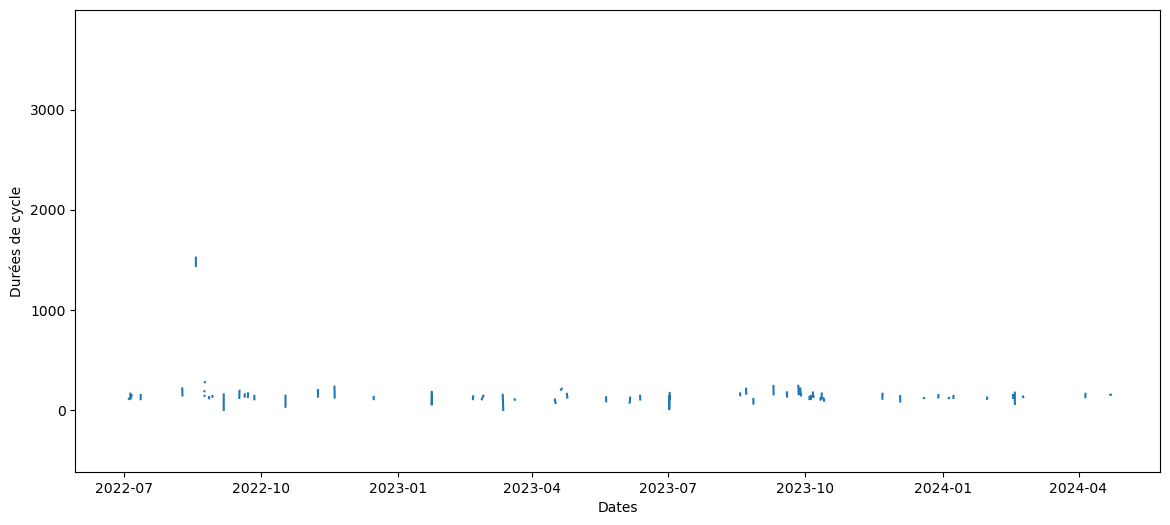

In [10]:
#Visualisation des données

plt.figure(figsize=(14,6))
plt.plot(duree_cycle['Cuiseur1'])
plt.xlabel('Dates')
plt.ylabel('Durées de cycle')
#plt.ylim(0,2000)
plt.show()

#### Identification du nombre de valeurs manquantes

In [20]:
print(duree_cycle.isnull().sum())

m_name         0
Cuiseur1    9528
Cuiseur2    8810
Cuiseur3    9322
dtype: int64


#### Création du dataframe contenant les nombres de cycle par jour

In [11]:
cycle_jour = duree_cycle.resample('D').count()
del cycle_jour['m_name']
cycle_jour.head()

,Cuiseur1,Cuiseur2,Cuiseur3
time,,,
2022-07-01,3,5,4
2022-07-02,2,10,4
2022-07-03,2,3,1
2022-07-04,5,7,5
2022-07-05,8,7,8


#### Identification et imputation des valeurs aberrantes par la médiane

In [26]:
cycle_jour.describe()

,Cuiseur1,Cuiseur2,Cuiseur3
count,673.000000,673.000000,673.000000
mean,6.401189,7.468053,6.707281
std,3.291782,3.685469,3.438086
min,0.000000,0.000000,0.000000
25%,4.000000,5.000000,4.000000
50%,7.000000,9.000000,8.000000
75%,9.000000,10.000000,9.000000
max,13.000000,15.000000,14.000000


In [28]:
cycle_jour.loc[cycle_jour['Cuiseur2'] >= 13,:] 

,Cuiseur1,Cuiseur2,Cuiseur3
time,,,
2022-08-12,8,13,8
2022-08-24,12,15,14
2023-11-28,11,13,11
2024-01-09,10,13,10


#### Visualisation finale de notre dataset

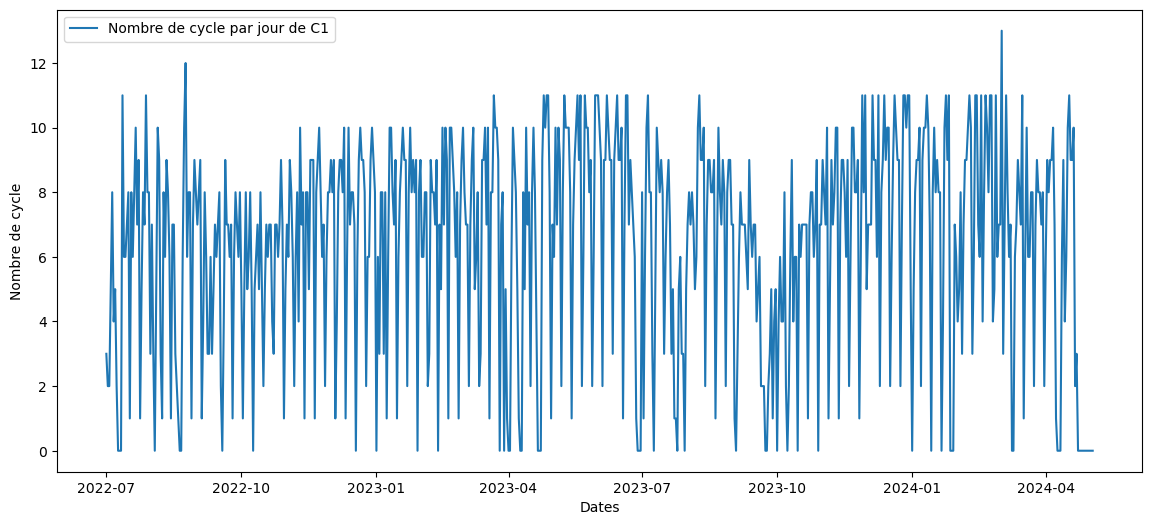

In [29]:
plt.figure(figsize=(14,6))
plt.plot(cycle_jour['Cuiseur1'], label='Nombre de cycle par jour de C1')
plt.xlabel('Dates')
plt.ylabel('Nombre de cycle')
plt.legend()
plt.show()

#### Analyse de la tendance et de la saisonnalité dans nos données

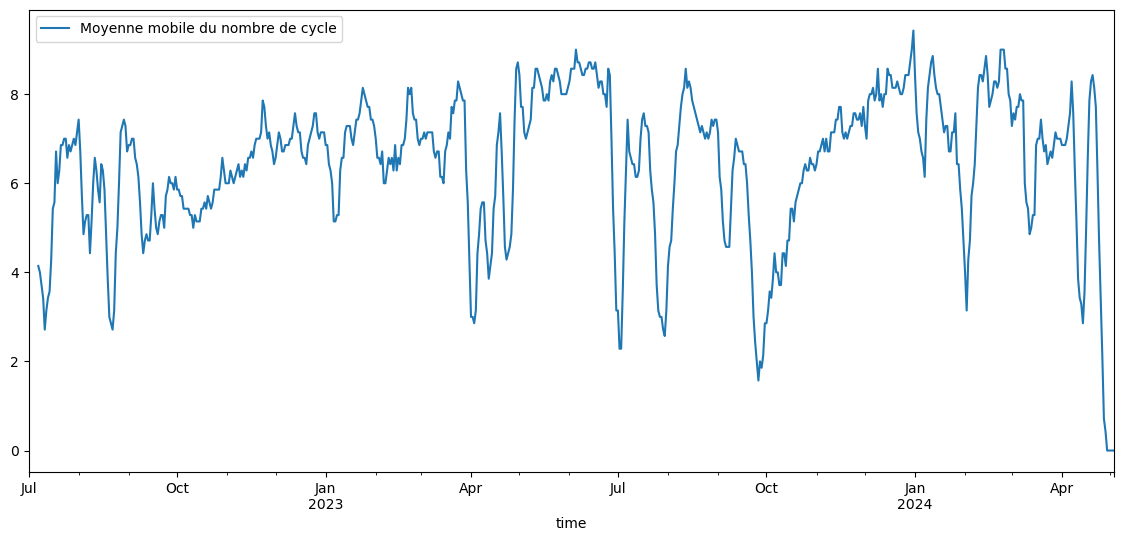

In [30]:
sma = pd.DataFrame()
sma['nb_cycle'] = cycle_jour['Cuiseur1'].rolling(window=7).mean()
sma['nb_cycle'].plot(figsize=(14,6), label='Moyenne mobile du nombre de cycle')
#cycle_jour['Cuiseur1'].plot(label='Cuiseur1')
plt.legend()
plt.show()

<Figure size 1400x600 with 0 Axes>

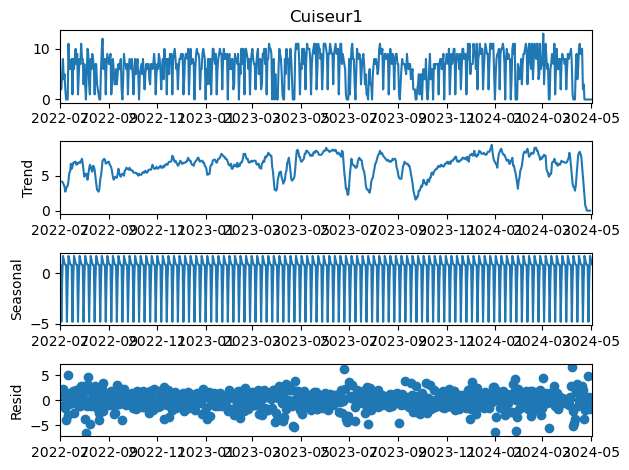

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(cycle_jour['Cuiseur1'], model='add', period=7)
plt.figure(figsize=(14,6))
decompose.plot()
plt.show()

#### Vérification de la stationnarité de notre série

In [36]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(cycle_jour['Cuiseur1'])
print('Test statistic : ', result[0])
print('P-value : ', result[1])
if (result[1]<0.05):
    print('Votre série est stationnaire')
else :
    print('Votre série n\'est pas stationnaire')

Test statistic :  -2.563215708457542
P-value :  0.10084061967498276
Votre série n'est pas stationnaire


#### Stationnarisation de notre série

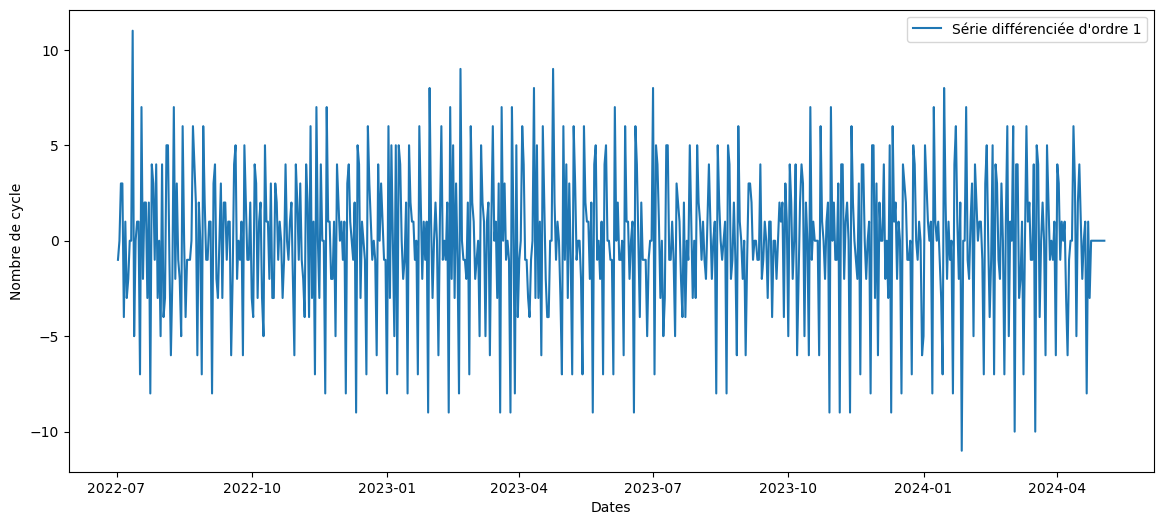

In [38]:
y_diff1 = cycle_jour['Cuiseur1'].diff(periods=1)
plt.figure(figsize=(14,6))
plt.plot(y_diff1, label='Série différenciée d\'ordre 1')
plt.xlabel('Dates')
plt.ylabel('Nombre de cycle')
plt.legend()
plt.show()

In [41]:
result = adfuller(y_diff1.dropna())
print('Test statistic : ', result[0])
print('P-value : ', result[1])
if (result[1]<0.05):
    print('Votre série est stationnaire')
else :
    print('Votre série n\'est pas stationnaire')

Test statistic :  -8.614995388684969
P-value :  6.325591561711238e-14
Votre série est stationnaire


#### Train-Test split de nos données

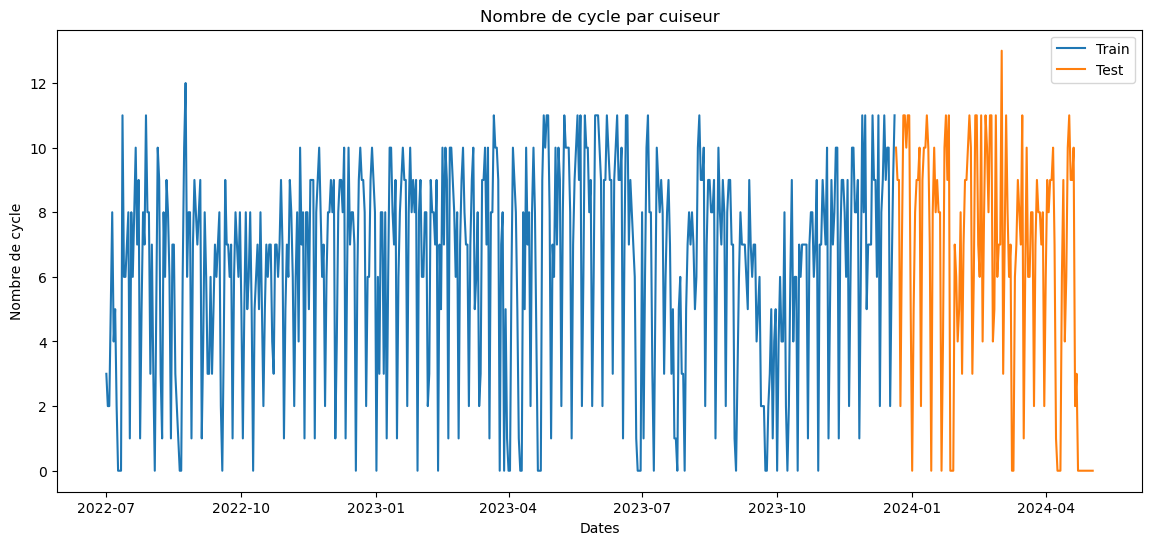

In [12]:
train = cycle_jour.loc[cycle_jour.index < '2023-12-21']
test = cycle_jour.loc[cycle_jour.index >= '2023-12-21']

plt.figure(figsize=(14,6))
plt.plot(train['Cuiseur1'], label='Train')
plt.plot(test['Cuiseur1'], label='Test')
plt.xlabel('Dates')
plt.ylabel('Nombre de cycle')
plt.title('Nombre de cycle par cuiseur')
plt.legend()
plt.show()

## Choix des paramètres du modèle

### Visualisation du graphe ACF et du graphe PACF

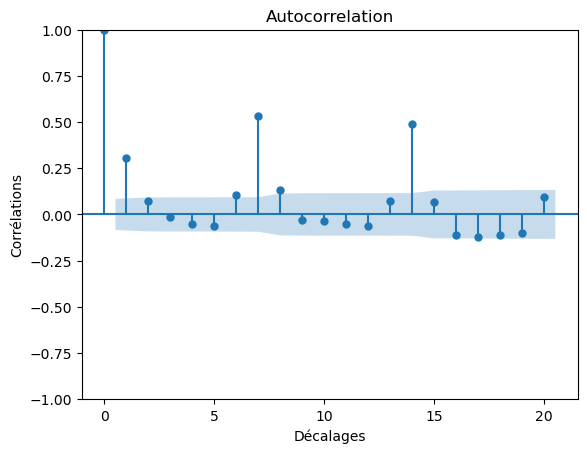

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train['Cuiseur1'], lags=20)
plt.xlabel('Décalages')
plt.ylabel('Corrélations')
plt.show()

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


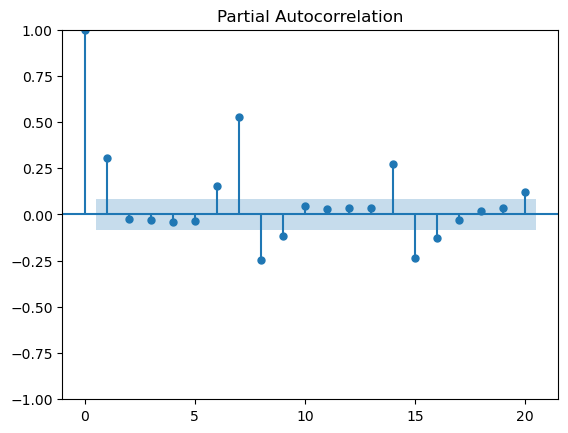

In [46]:
plot_pacf(train['Cuiseur1'], lags=20)
plt.show()

Puisque nous avons des pics qui décroissent encore lentement vers 0, nous allons effectuer une seconde différenciation d'ordre 7.

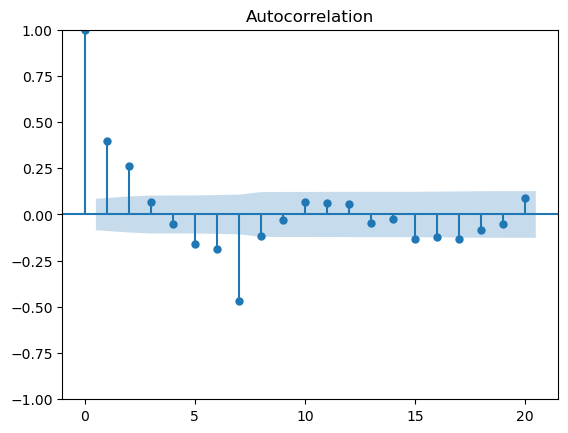

In [47]:
plot_acf(train['Cuiseur1'].diff(periods=7).dropna(), lags=20)
plt.show()

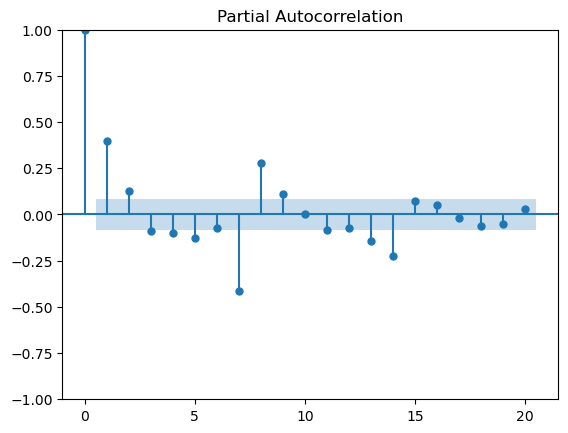

In [48]:
plot_pacf(train['Cuiseur1'].diff(periods=7).dropna(), lags=20)
plt.show()

On fait une première estimation du SARIMA(8,1,2)(0,1,0,7)

## Entraînement du modèle

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Sarima_model = SARIMAX(train['Cuiseur1'], order=(6,1,2), seasonal_order=(2,1,2,7))
Sarima_result = Sarima_model.fit()

print(Sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          Cuiseur1   No. Observations:                  538
Model:             SARIMAX(6, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -1143.612
Date:                           Mon, 20 May 2024   AIC                           2313.224
Time:                                   13:35:15   BIC                           2368.772
Sample:                               07-01-2022   HQIC                          2334.966
                                    - 12-20-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1725      0.946     -0.182      0.855      -2.026       1.681
ar.L2          0.3179      0.293      1.087

In [52]:
Auto_arma_model2 = pm.auto_arima(train['Cuiseur1'], start_p=1, start_q=1, test='adf', max_p=18, max_q=18, d=1, m=7, seasonal=True, error_action='ignore', D=1, trace=True, stepwise=True, suppress_warnings=True)
print(Auto_arma_model2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2776.505, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2530.733, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2691.936, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=2486.800, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=2578.592, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=2477.829, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=2524.008, Time=0.30 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.77 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=2472.738, Time=1.02 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=2520.513, Time=1.96 s

In [20]:
Sarima_model = SARIMAX(train['Cuiseur1'], order=(6,1,0), seasonal_order=(2,1,0,7))
Sarima_result = Sarima_model.fit()

print(Sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          Cuiseur1   No. Observations:                  538
Model:             SARIMAX(6, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -1213.694
Date:                           Mon, 20 May 2024   AIC                           2445.388
Time:                                   13:37:52   BIC                           2483.844
Sample:                               07-01-2022   HQIC                          2460.441
                                    - 12-20-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5526      0.038    -14.685      0.000      -0.626      -0.479
ar.L2         -0.2999      0.045     -6.707

## Prévisions à partir de notre modèle

### Génération des prédictions

In [21]:
Conso_pred = Sarima_result.get_forecast(len(test.index))
Conso_pred_df = Conso_pred.conf_int(alpha = 0.05) 
Conso_pred_df["Predictions"] = Sarima_result.predict(start = Conso_pred_df.index[0], end = Conso_pred_df.index[-1])
Conso_pred_df.index = test.index
Conso_pred_out = Conso_pred_df["Predictions"] 
display(Conso_pred_df)

,lower Cuiseur1,upper Cuiseur1,Predictions
time,,,
2023-12-21,5.755529,15.084645,10.420087
2023-12-22,2.836940,13.057051,7.946995
2023-12-23,4.788438,15.847490,10.317964
2023-12-24,-1.631240,9.900661,4.134710
2023-12-25,1.545403,13.360305,7.452854
...,...,...,...
2024-04-29,-97.065159,120.621641,11.778241
2024-04-30,-95.751265,124.036888,14.142812
2024-05-01,-95.260265,126.627855,15.683795


In [22]:
Conso_pred_df.describe()

,lower Cuiseur1,upper Cuiseur1,Predictions
count,135.000000,135.000000,135.000000
mean,-38.825620,60.684194,10.929287
std,31.402784,34.258179,2.868262
min,-100.061810,9.900661,3.047428
25%,-64.643299,29.998728,9.690246
50%,-34.175940,56.363445,11.443825
75%,-10.710220,88.385534,13.047369
max,5.755529,127.042746,15.683795


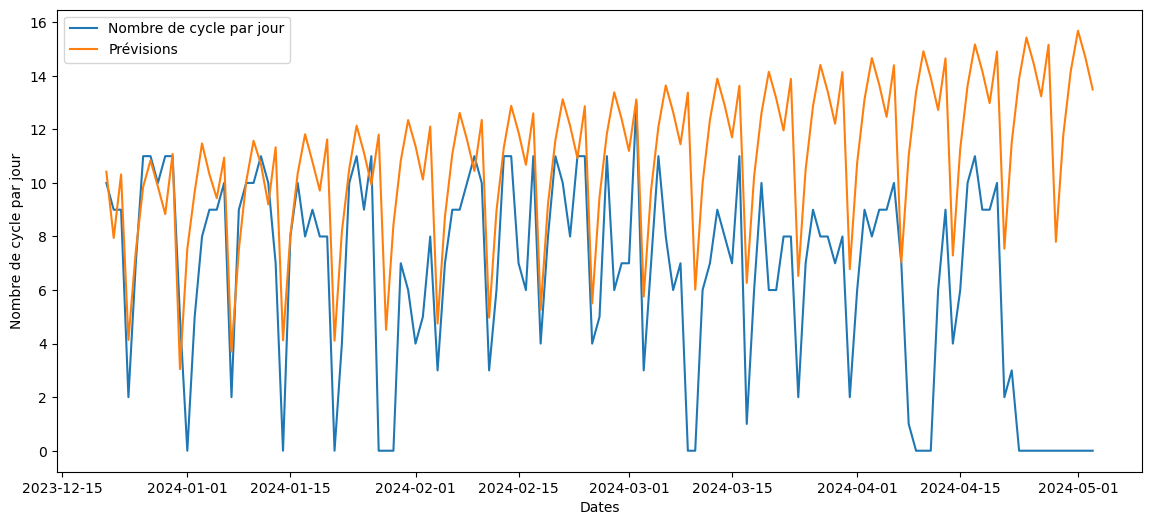

In [66]:
plt.figure(figsize=(14,6))
plt.plot(test['Cuiseur1'], label='Nombre de cycle par jour')
plt.plot(Conso_pred_df['Predictions'], label='Prévisions')
plt.xlabel('Dates')
plt.ylabel('Nombre de cycle par jour')
plt.legend()
plt.show()

### Validation du modèle

In [67]:
error1 = test['Cuiseur1']-Conso_pred_df['Predictions']
rmse1 = np.sqrt((error1**2).mean())
print(rmse1)

6.073914430046812


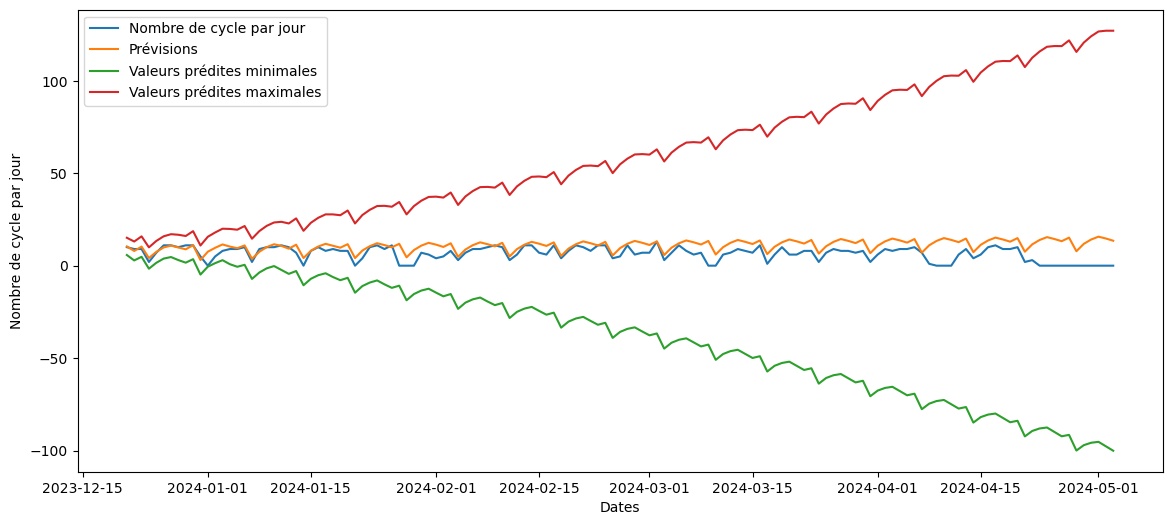

In [68]:
plt.figure(figsize=(14,6))
plt.plot(test['Cuiseur1'], label='Nombre de cycle par jour')
plt.plot(Conso_pred_df['Predictions'], label='Prévisions')
plt.plot(Conso_pred_df['lower Cuiseur1'], label='Valeurs prédites minimales')
plt.plot(Conso_pred_df['upper Cuiseur1'], label='Valeurs prédites maximales')
plt.xlabel('Dates')
plt.ylabel('Nombre de cycle par jour')
plt.legend()
plt.show()

### Visualisation des résidus

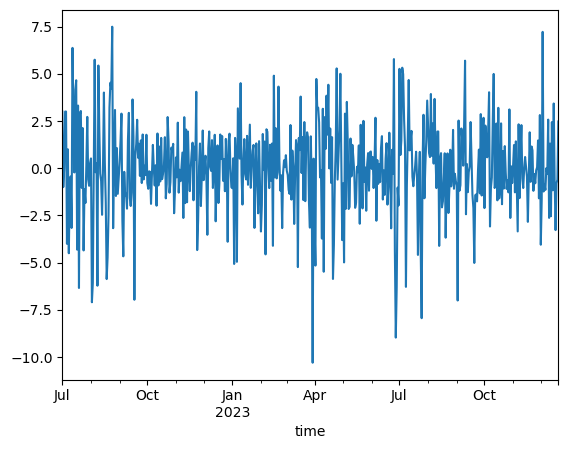

In [69]:
resid = Sarima_result.resid
resid.plot()
plt.show()

In [70]:
result = adfuller(resid)
print('Test statistic : ', result[0])
print('P-value : ', result[1])
if (result[1]<0.05):
    print('Votre résidu est stationnaire')
else :
    print('Votre résidu n\'est pas stationnaire')

Test statistic :  -8.507802606191927
P-value :  1.18976976295739e-13
Votre résidu est stationnaire


## Interprétations

In [71]:
Conso_pred_df.describe()

,lower Cuiseur1,upper Cuiseur1,Predictions
count,135.000000,135.000000,135.000000
mean,-38.825620,60.684194,10.929287
std,31.402784,34.258179,2.868262
min,-100.061810,9.900661,3.047428
25%,-64.643299,29.998728,9.690246
50%,-34.175940,56.363445,11.443825
75%,-10.710220,88.385534,13.047369
max,5.755529,127.042746,15.683795


### Création des caractéristiques

In [73]:
def create_feature(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [75]:
cycle_jour.index = pd.to_datetime(cycle_jour.index, format='%d/%m/%Y')
cycle_jour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2022-07-01 to 2024-05-03
Freq: D
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Cuiseur1  673 non-null    int64
 1   Cuiseur2  673 non-null    int64
 2   Cuiseur3  673 non-null    int64
dtypes: int64(3)
memory usage: 37.2 KB


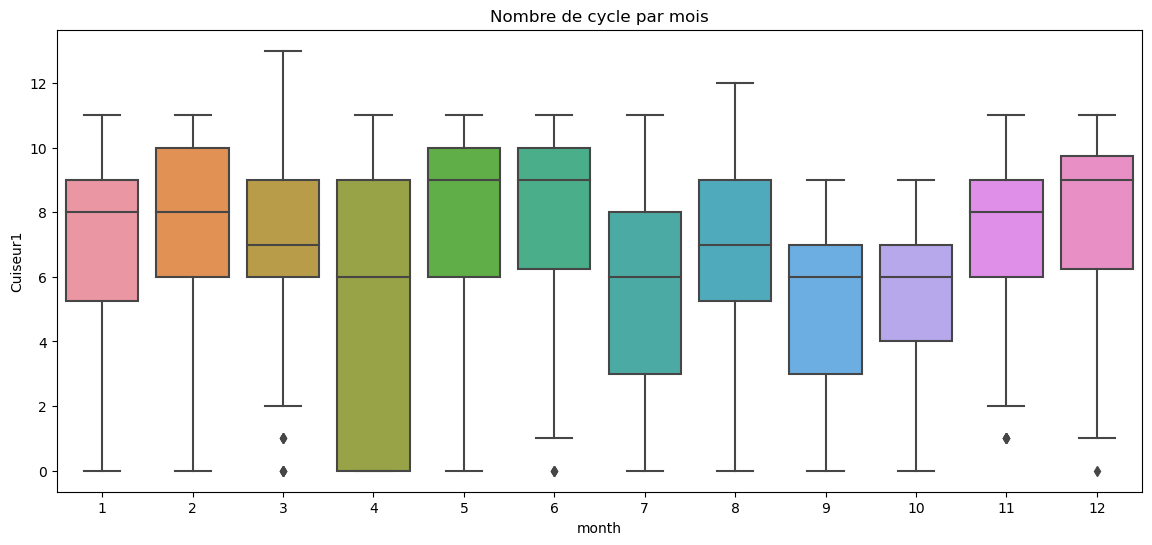

In [77]:
Feat = create_feature(cycle_jour)
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=Feat, x='month', y='Cuiseur1')
ax.set_title('Nombre de cycle par mois')
plt.show()

### Corrélation entre nos nombres de cycle et la température de la météo

In [13]:
Tj = pd.DataFrame()
Tj['Date'] = Temp['location']
Tj['Temperature'] = Temp['Bâle.2']
Tj.set_index('Date', inplace=True)
Tj.index = pd.to_datetime(Tj.index)
Tj['Temperature'] = Tj['Temperature'].astype(float)
Tj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 696 entries, 2022-06-08 to 2024-05-03
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  688 non-null    float64
dtypes: float64(1)
memory usage: 10.9 KB


In [14]:
data = pd.merge(cycle_jour, Tj, left_on='time', right_on='Date')
data.head()

,Cuiseur1,Cuiseur2,Cuiseur3,Temperature
0,3,5,4,17.324831
1,2,10,4,20.103579
2,2,3,1,23.683998
3,5,7,5,22.158997
4,8,7,8,22.266077


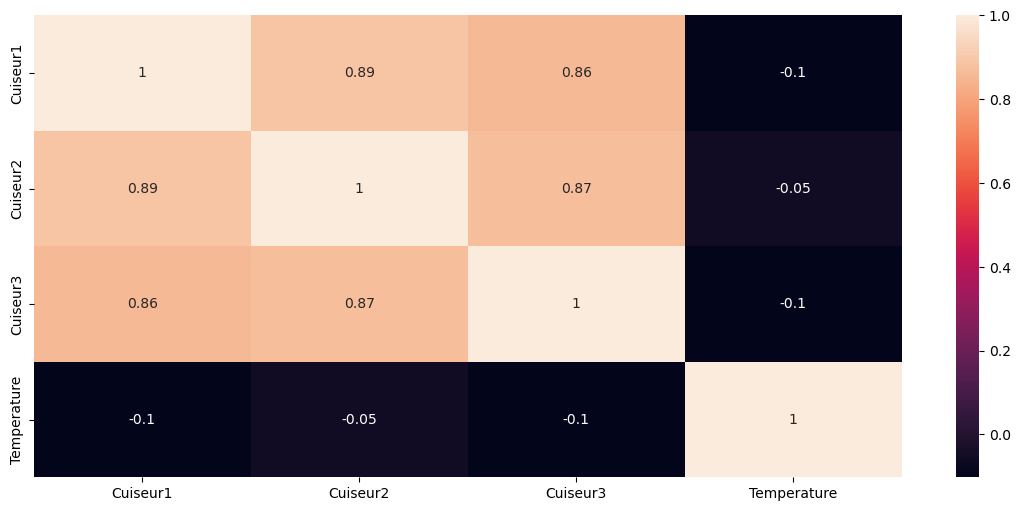

In [15]:
corr = data.corr()

plt.figure(figsize=(14,6))
sns.heatmap(corr, annot=True)
plt.show()

#### Max Min nombre de cycle

In [26]:
Conso_pred_df.loc[Conso_pred_df['Predictions'] > 15]

,lower Cuiseur1,upper Cuiseur1,Predictions
time,,,
2024-04-17,-79.954851,110.300156,15.172653
2024-04-24,-87.505555,118.362025,15.428235
2024-04-27,-91.497675,121.819128,15.160727
2024-05-01,-95.260265,126.627855,15.683795


### Corrélation entre la température de la vapeur et la température dans les cuiseurs

#### Traitement des données

In [27]:
temp_mar2 = pd.DataFrame()
temp_mar2 = temp_mar.copy()
temp_mar2.set_index('time', inplace=True)
temp_mar2.index=pd.to_datetime(temp_mar2.index)
temp_mar2.head()

,m_name,Cuiseur1,Cuiseur2,Cuiseur3
time,,,,
2022-06-08 13:52:00,Temperature_Process,100.592079,101.947144,NaN
2022-06-08 13:53:00,Temperature_Process,100.689735,102.069221,NaN
2022-06-08 13:54:00,Temperature_Process,100.567657,102.057007,NaN
2022-06-08 13:55:00,Temperature_Process,100.616493,102.215714,NaN
2022-06-08 13:56:00,Temperature_Process,100.701950,102.398827,NaN


In [28]:
temp_mar_j = temp_mar2.resample('D').mean()
temp_mar_j.head()

C:\Users\yanni\AppData\Local\Temp\ipykernel_14236\4049126410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_mar_j = temp_mar2.resample('D').mean()


,Cuiseur1,Cuiseur2,Cuiseur3
time,,,
2022-06-08,103.729848,102.503819,101.592292
2022-06-09,102.669761,101.069187,101.629126
2022-06-10,102.776398,101.200218,101.163568
2022-06-11,102.745873,101.883377,101.952695
2022-06-12,103.854722,102.669512,102.896391


In [29]:
vapeur.set_index('time', inplace=True)
vapeur.index = pd.to_datetime(vapeur.index)
vap_jour = vapeur.resample('D').mean()
vap_jour.head()

C:\Users\yanni\AppData\Local\Temp\ipykernel_14236\3129461362.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vap_jour = vapeur.resample('D').mean()


,Collecteur_COP_Vapeur,Cuiseur_1,Cuiseur_2,Cuiseur_3
time,,,,
2021-12-01,182.759366,179.158549,180.617026,137.046359
2021-12-02,184.080816,180.795083,182.187348,108.576586
2021-12-03,180.931913,177.566069,177.601352,179.054607
2021-12-04,182.193196,164.698355,178.880343,180.221429
2021-12-05,165.511553,161.421292,158.034364,99.179006


In [30]:
fusion = pd.merge(temp_mar_j, vap_jour, left_on='time', right_on='time')
fusion.head()

,Cuiseur1,Cuiseur2,Cuiseur3,Collecteur_COP_Vapeur,Cuiseur_1,Cuiseur_2,Cuiseur_3
time,,,,,,,
2022-06-08,103.729848,102.503819,101.592292,182.863986,180.381838,181.100493,181.826982
2022-06-09,102.669761,101.069187,101.629126,182.568192,180.102327,180.753786,181.383466
2022-06-10,102.776398,101.200218,101.163568,182.621335,180.079741,180.893169,181.152726
2022-06-11,102.745873,101.883377,101.952695,183.107576,180.413801,181.323458,181.904910
2022-06-12,103.854722,102.669512,102.896391,172.187402,171.019957,170.746159,172.884029


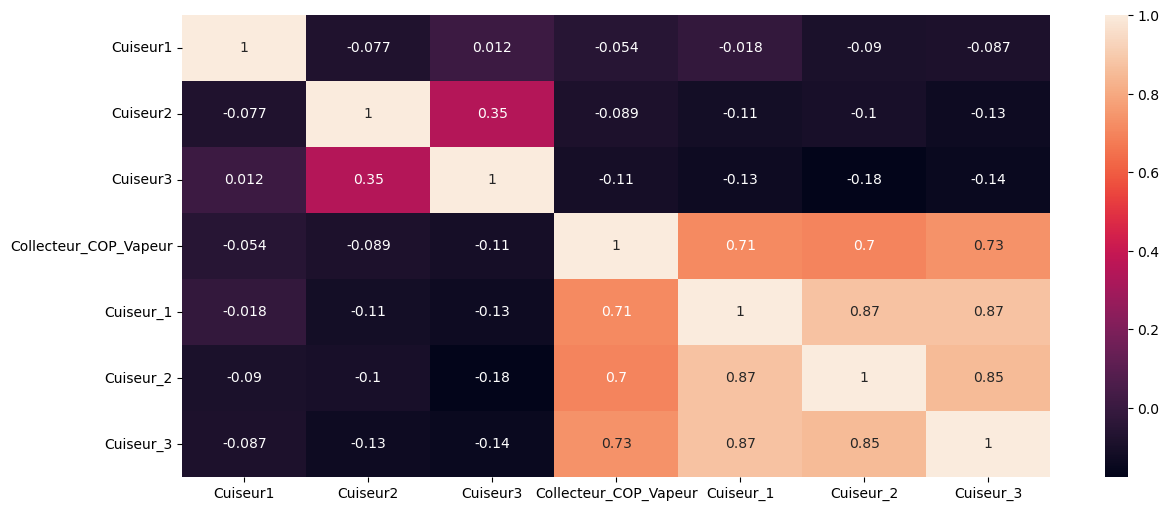

In [31]:
corr3 = fusion.corr()

plt.figure(figsize=(14,6))
sns.heatmap(corr3, annot=True)
plt.show()

### Corrélation entre la durée de cycle et le poids de la matière

#### Préparation des données de poids

In [32]:
poids.set_index('Temps', inplace=True)
poids.index = pd.to_datetime(poids.index)
poids.head()

,C3 Prod,C2 Prod,C1 Prod
Temps,,,
2022-07-04 02:31:00,NaN,1.429,NaN
2022-07-04 03:12:00,NaN,NaN,1.356
2022-07-04 04:22:00,NaN,44.370,NaN
2022-07-04 05:24:00,NaN,NaN,1.298
2022-07-04 09:44:00,53.24,NaN,NaN


In [33]:
poids.describe()

,C3 Prod,C2 Prod,C1 Prod
count,495672.00000,481133.000000,455635.000000
mean,4127.92835,4499.206909,3922.753491
std,1111.71741,1294.283255,1098.348796
min,-135.00000,-361.000000,0.748000
25%,3249.00000,3471.000000,3040.000000
50%,4013.00000,4331.000000,3761.000000
75%,5009.00000,5564.000000,4762.000000
max,43433.33000,141600.000000,23983.330000


In [34]:
poids.loc[poids['C3 Prod'] > 1000]

,C3 Prod,C2 Prod,C1 Prod
Temps,,,
2022-11-04 11:14:00,6423.81,NaN,NaN
2022-11-04 14:06:00,1066.41,NaN,NaN
2022-04-15 14:45:00,1159.65,NaN,NaN
2022-04-18 09:08:00,42833.33,NaN,NaN
2022-04-18 12:20:00,43433.33,NaN,NaN
...,...,...,...
2024-12-03 12:59:00,4440.00,5824.0,NaN
2024-12-03 13:00:00,4422.00,5754.0,NaN
2024-12-03 13:01:00,4394.00,5644.0,NaN
